In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# 2. Load and Explore Data
df = pd.read_csv("data/cars.csv")

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)

Dataset shape: (398, 9)

First 5 rows:
    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  

Data types:
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: obje

In [4]:
# 3. Data Cleaning - Handle Missing Values
df['horsepower'] = df['horsepower'].replace('?', np.nan)
df['horsepower'] = pd.to_numeric(df['horsepower'])
print(df.isnull().sum())

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [5]:
# 4. Feature
target = "mpg"
features = ["cylinders", "displacement", "horsepower", "weight",
            "acceleration", "model year", "origin"]

# Select features and drop missing values
df_clean = df[features + [target]].dropna().copy()

# One-hot encode origin
df_clean = pd.get_dummies(df_clean, columns=['origin'], prefix='origin', drop_first=True)

print(f"{len(df_clean)} (removed {len(df) - len(df_clean)})")

df_clean.columns.tolist()

392 (removed 6)


['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model year',
 'mpg',
 'origin_2',
 'origin_3']

In [6]:
# 5. Split Data into Train/Validation/Test Sets (70%/15%/15%)
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Split: separate test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Split: separate validation from training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.176, random_state=42
)

print(f"Training set:   {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set:       {len(X_test)} samples")

Training set:   274 samples
Validation set: 59 samples
Test set:       59 samples


In [7]:
# 6. Train Baseline Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate TRAINING
y_train_pred = lr.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate VALIDATION
y_val_pred = lr.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training   | RMSE: {train_rmse:.2f} mpg | R²: {train_r2:.3f}")
print(f"Validation | RMSE: {val_rmse:.2f} mpg | R²: {val_r2:.3f}")


Training   | RMSE: 3.29 mpg | R²: 0.823
Validation | RMSE: 3.53 mpg | R²: 0.790


In [8]:
# 7. Fine Tuning - Test Multiple Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=0.1)': Ridge(alpha=0.1),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=10)': Ridge(alpha=10),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
}

print("HYPERPARAMETER (on validation set)")


results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    results.append({'Model': name, 'R²': val_r2, 'RMSE': val_rmse})
    print(f"{name:20s} | R²: {val_r2:.3f} | RMSE: {val_rmse:.2f}")

HYPERPARAMETER (on validation set)
Linear Regression    | R²: 0.790 | RMSE: 3.53
Ridge (α=0.1)        | R²: 0.790 | RMSE: 3.53
Ridge (α=1.0)        | R²: 0.792 | RMSE: 3.52
Ridge (α=10)         | R²: 0.798 | RMSE: 3.46
Lasso (α=0.1)        | R²: 0.802 | RMSE: 3.43


In [9]:
# Train model on Lasso
best_model = Lasso(alpha=0.1)
best_model.fit(X_train_full, y_train_full)

# Evaluate on TEST set
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"RMSE: {test_rmse:.2f} mpg")
print(f"MAE:  {test_mae:.2f} mpg")
print(f"R²:   {test_r2:.3f}")


RMSE: 2.99 mpg
MAE:  2.30 mpg
R²:   0.847


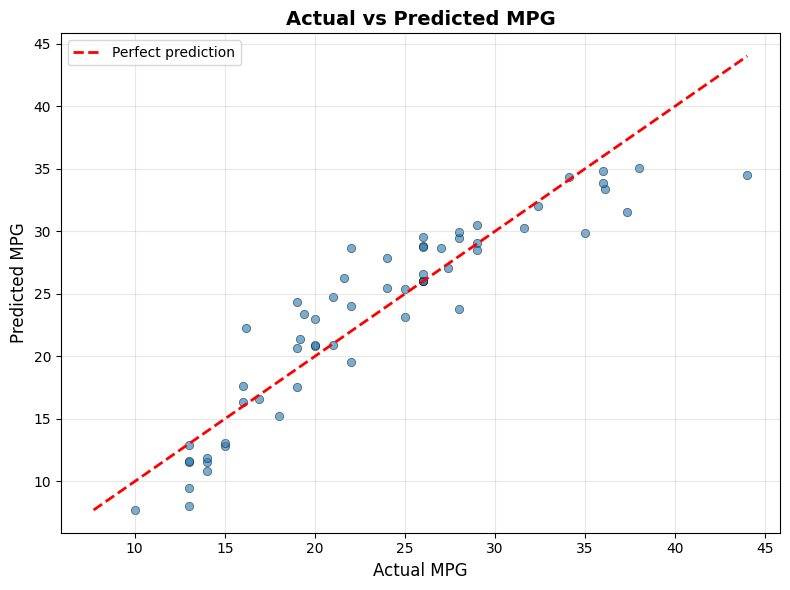

In [16]:
# 9. Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', linewidth=0.5)

min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')

plt.xlabel('Actual MPG', fontsize=12)
plt.ylabel('Predicted MPG', fontsize=12)
plt.title('Actual vs Predicted MPG', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


plt.savefig('regression_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>